In [1]:
import os
import numpy as np
import pandas as pd
import os.path as osp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


from ruamel.yaml import YAML
from scipy.signal import savgol_filter
from datetime import datetime
yaml = YAML(typ="safe", pure=True)

%matplotlib inline

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


def smooth(y, radius, mode="two_sided", valid_only=False):
    """
    Smooth signal y, where radius is determines the size of the window
    mode='twosided':
        average over the window [max(index - radius, 0), min(index + radius, len(y)-1)]
    mode='causal':
        average over the window [max(index - radius, 0), index]
    valid_only: put nan in entries where the full-sized window is not available
    """
    assert mode in ("two_sided", "causal")
    if len(y) < 2 * radius + 1:
        return np.ones_like(y) * y.mean()
    elif mode == "two_sided":
        convkernel = np.ones(2 * radius + 1)
        out = np.convolve(y, convkernel, mode="same") / np.convolve(
            np.ones_like(y), convkernel, mode="same"
        )
        if valid_only:
            out[:radius] = out[-radius:] = np.nan
    elif mode == "causal":
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel, mode="full") / np.convolve(
            np.ones_like(y), convkernel, mode="full"
        )
        out = out[: -radius + 1]
        if valid_only:
            out[:radius] = np.nan
    return out


smooth_2 =  lambda y : savgol_filter(y, 51, 3) # window size 51, polynomial order 3

def load_yaml(path: str):
    with open(path, 'r') as f:
        conf = yaml.load(f)
    conf = pd.io.json.json_normalize(conf)
    return conf

def load_csv_result(path: str):
    res = pd.read_csv(path, sep='\t')
    res['score-smooth'] = smooth(res['score'], 20)
    res['score-smooth-more'] = smooth_2(res['score-smooth'])
    return res

def collect_and_merge_data(path):
    ''' Recursively search in folder to create a dataframe of experiment.
    Search for configs.json / progress.txt in order to create
    a dataframe containsing all experiments.
    '''
    data, idexp = [], 0
    for root, directories, files in os.walk(path):
        if 'progress.csv' in files and 'conf.yaml' in files:
            try:                
                c1 = load_yaml(os.path.join(root, 'conf.yaml'))
                c2 = load_csv_result(os.path.join(root, 'progress.csv'))
                c3 = pd.concat([c1] * c2.shape[0])
                c3.index = c2.index
                c4 = pd.concat([c3, c2], 1)
                data.append(c4)
            except Exception as  e:
                print(root, e)
    return pd.concat(data, axis=0)



mpl.rcParams['axes.linewidth']  = 1.5
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['xtick.labelsize'] = 'x-small'
mpl.rcParams['ytick.labelsize'] = 'x-small'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.figsize']  = (20,8)

""" Visualization of Mujoco """

colors  = ["#353b48", "#e84118"]
palette = sns.color_palette(colors)
width   = 345

In [8]:
DATA = collect_and_merge_data('./logs')

/home/tau/nmakdoud/miniconda3/envs/core/lib/python3.7/site-packages/ipykernel_launcher.py:86: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [10]:
num_commit_opts = DATA['rl.kwargs.num_commit'].unique()
pi_reuse_opts   = DATA['rl.kwargs.pi_reuse'].unique()
env_opts        = DATA['env.name'].unique()

print(num_commit_opts)
print(pi_reuse_opts)
print(env_opts)

[ 1 10  5]
[0.2]
['HalfCheetahSmallLeg-v1' 'HalfCheetahBigThigh-v1'
 'HalfCheetahBigTorso-v1' 'HalfCheetahGravityOneAndHalf-v1'
 'HalfCheetahGravityOneAndQuarter-v1' 'HalfCheetahSmallFoot-v1'
 'HalfCheetahSmallTorso-v1' 'HalfCheetahBigFoot-v1'
 'HalfCheetahGravityThreeQuarters-v1' 'HalfCheetahGravityHalf-v1'
 'HalfCheetahSmallThigh-v1' 'HalfCheetahBigLeg-v1' 'HopperGravityHalf-v1'
 'HopperGravityThreeQuarters-v1' 'HopperGravityOneAndQuarter-v1'
 'HopperGravityOneAndHalf-v1' 'HopperSmallFoot-v1' 'HopperSmallLeg-v1'
 'HopperSmallTorso-v1' 'HopperSmallThigh-v1' 'HopperBigFoot-v1'
 'HopperBigThigh-v1' 'HopperBigTorso-v1' 'HopperBigLeg-v1'
 'Walker2dGravityHalf-v1' 'Walker2dGravityThreeQuarters-v1'
 'Walker2dGravityOneAndQuarter-v1' 'Walker2dGravityOneAndHalf-v1'
 'Walker2dSmallFoot-v1' 'Walker2dSmallLeg-v1' 'Walker2dSmallTorso-v1'
 'Walker2dSmallThigh-v1' 'Walker2dBigFoot-v1' 'Walker2dBigThigh-v1'
 'Walker2dBigTorso-v1' 'Walker2dBigLeg-v1']


In [11]:
data.keys()

Index(['batch_size', 'device', 'experiment', 'experts_path',
       'ignore_timeout_done', 'log_save_interval', 'num_batches', 'num_epochs',
       'seed', 'actor.cls', 'actor.kwargs.action_nd', 'actor.kwargs.input_nd',
       'actor.kwargs.mlp_hidden_len', 'actor_optim.cls',
       'actor_optim.kwargs.lr', 'common.rl.action_epsilon_nz',
       'common.rl.action_epsilon_rnd', 'common.rl.device', 'common.rl.gamma',
       'common.rl.max_grad_norm', 'common.rl.polyak', 'critic.cls',
       'critic.kwargs.action_nd', 'critic.kwargs.input_nd',
       'critic.kwargs.mlp_hidden_len', 'critic_optim.cls',
       'critic_optim.kwargs.lr', 'env.action_nd', 'env.loader', 'env.name',
       'env.observation_nd', 'memory.kwargs.size', 'rl.cls',
       'rl.kwargs.lam_pi_guidance', 'rl.kwargs.num_commit',
       'rl.kwargs.pi_reuse', 'rl.kwargs.reuse', 'rl.kwargs.use_pi_guidance',
       'rl.kwargs.use_q_guidance', 'runner.kwargs.horizon',
       'runner.kwargs.random_init', 'training_score', 'timest

In [34]:
env_opts

array(['HalfCheetahSmallLeg-v1', 'HalfCheetahBigThigh-v1',
       'HalfCheetahBigTorso-v1', 'HalfCheetahGravityOneAndHalf-v1',
       'HalfCheetahGravityOneAndQuarter-v1', 'HalfCheetahSmallFoot-v1',
       'HalfCheetahSmallTorso-v1', 'HalfCheetahBigFoot-v1',
       'HalfCheetahGravityThreeQuarters-v1', 'HalfCheetahGravityHalf-v1',
       'HalfCheetahSmallThigh-v1', 'HalfCheetahBigLeg-v1',
       'HopperGravityHalf-v1', 'HopperGravityThreeQuarters-v1',
       'HopperGravityOneAndQuarter-v1', 'HopperGravityOneAndHalf-v1',
       'HopperSmallFoot-v1', 'HopperSmallLeg-v1', 'HopperSmallTorso-v1',
       'HopperSmallThigh-v1', 'HopperBigFoot-v1', 'HopperBigThigh-v1',
       'HopperBigTorso-v1', 'HopperBigLeg-v1', 'Walker2dGravityHalf-v1',
       'Walker2dGravityThreeQuarters-v1',
       'Walker2dGravityOneAndQuarter-v1', 'Walker2dGravityOneAndHalf-v1',
       'Walker2dSmallFoot-v1', 'Walker2dSmallLeg-v1',
       'Walker2dSmallTorso-v1', 'Walker2dSmallThigh-v1',
       'Walker2dBigFoot-v1', '

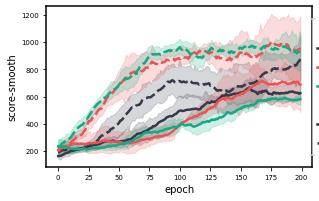

In [29]:
env = 'Walker2dSmallThigh-v1'

colors  = ["#353b48", "#ee5253", "#10ac84"]
palette = sns.color_palette(colors)

fig, ax = plt.subplots(1, 1, figsize=set_size(width))

df = DATA[(DATA['env.name'] == env)]
x  = sns.lineplot(x="epoch", y="score-smooth", data=df, palette=palette, ax=ax, hue='rl.kwargs.num_commit', style='rl.kwargs.reuse')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, mode="expand", borderaxespad=0, loc='center left', bbox_to_anchor=(1, 0.5))


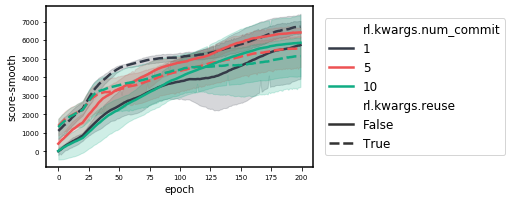

In [33]:
env = 'HalfCheetahBigFoot-v1'

colors  = ["#353b48", "#ee5253", "#10ac84"]
palette = sns.color_palette(colors)

fig, ax = plt.subplots(1, 1, figsize=set_size(width))

df = DATA[(DATA['env.name'] == env)]
x  = sns.lineplot(x="epoch", y="score-smooth", data=df, palette=palette, ax=ax, hue='rl.kwargs.num_commit', style='rl.kwargs.reuse')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, borderaxespad=1, loc='center left', bbox_to_anchor=(1, 0.5))


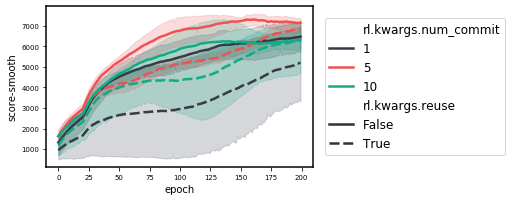

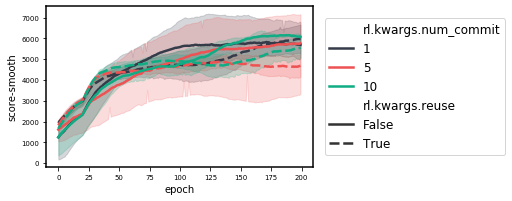

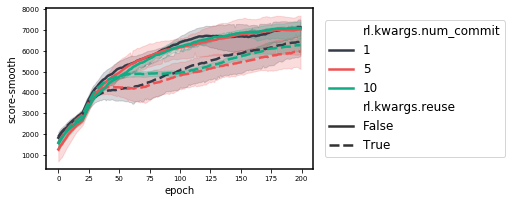

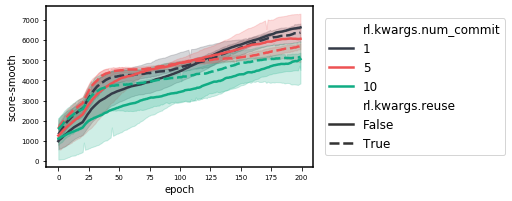

In [36]:
envs = ['HalfCheetahSmallLeg-v1', 'HalfCheetahBigThigh-v1', 'HalfCheetahBigTorso-v1', 'HalfCheetahBigLeg-v1']
for env in envs:
    fig, ax = plt.subplots(1, 1, figsize=set_size(width))

    df = DATA[(DATA['env.name'] == env)]
    x  = sns.lineplot(x="epoch", y="score-smooth", data=df, palette=palette, ax=ax, hue='rl.kwargs.num_commit', style='rl.kwargs.reuse')

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, labels=labels, borderaxespad=1, loc='center left', bbox_to_anchor=(1, 0.5))

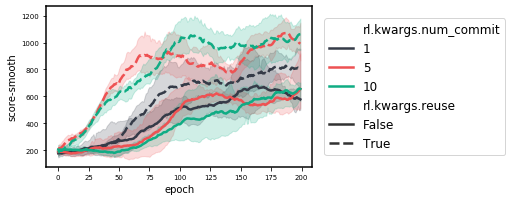

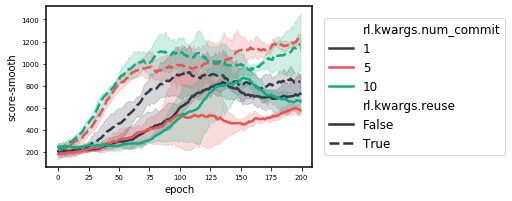

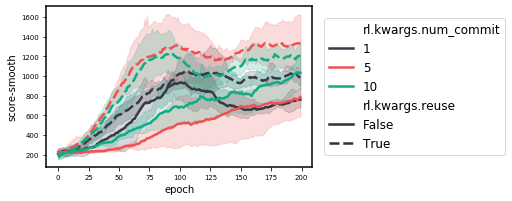

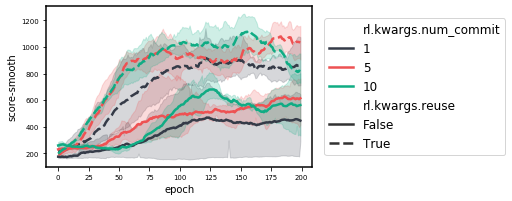

In [37]:
E = 'Walker2d'
envs = [f'{E}SmallLeg-v1', f'{E}BigThigh-v1', f'{E}BigTorso-v1', f'{E}BigLeg-v1']
for env in envs:
    fig, ax = plt.subplots(1, 1, figsize=set_size(width))

    df = DATA[(DATA['env.name'] == env)]
    x  = sns.lineplot(x="epoch", y="score-smooth", data=df, palette=palette, ax=ax, hue='rl.kwargs.num_commit', style='rl.kwargs.reuse')

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, labels=labels, borderaxespad=1, loc='center left', bbox_to_anchor=(1, 0.5))

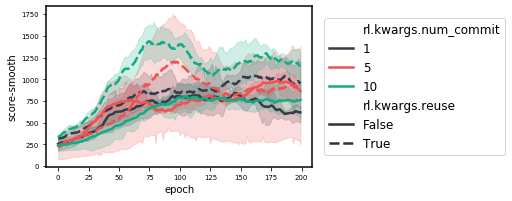

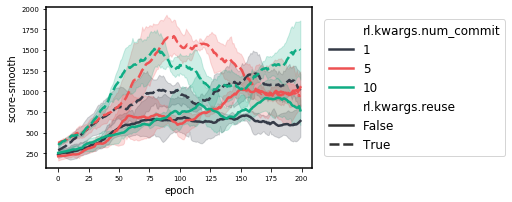

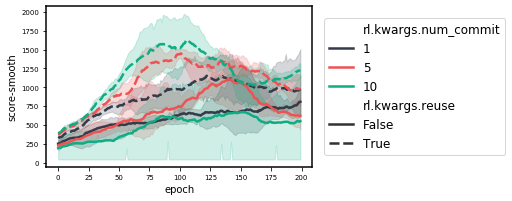

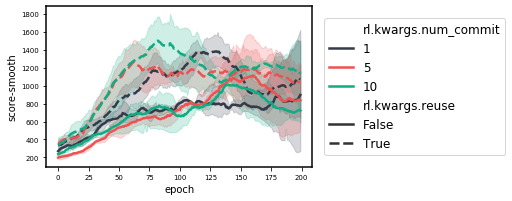

In [38]:
E = 'Hopper'
envs = [f'{E}SmallLeg-v1', f'{E}BigThigh-v1', f'{E}BigTorso-v1', f'{E}BigLeg-v1']
for env in envs:
    fig, ax = plt.subplots(1, 1, figsize=set_size(width))

    df = DATA[(DATA['env.name'] == env)]
    x  = sns.lineplot(x="epoch", y="score-smooth", data=df, palette=palette, ax=ax, hue='rl.kwargs.num_commit', style='rl.kwargs.reuse')

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, labels=labels, borderaxespad=1, loc='center left', bbox_to_anchor=(1, 0.5))

In [43]:
N = [e for e in DATA['env.name'].unique() if 'Gravity' in e]
N

['HalfCheetahGravityOneAndHalf-v1',
 'HalfCheetahGravityOneAndQuarter-v1',
 'HalfCheetahGravityThreeQuarters-v1',
 'HalfCheetahGravityHalf-v1',
 'HopperGravityHalf-v1',
 'HopperGravityThreeQuarters-v1',
 'HopperGravityOneAndQuarter-v1',
 'HopperGravityOneAndHalf-v1',
 'Walker2dGravityHalf-v1',
 'Walker2dGravityThreeQuarters-v1',
 'Walker2dGravityOneAndQuarter-v1',
 'Walker2dGravityOneAndHalf-v1']

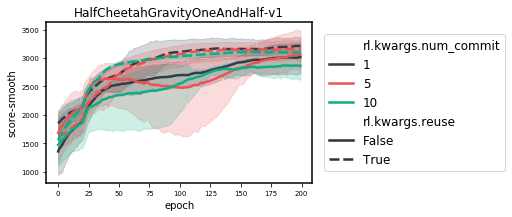

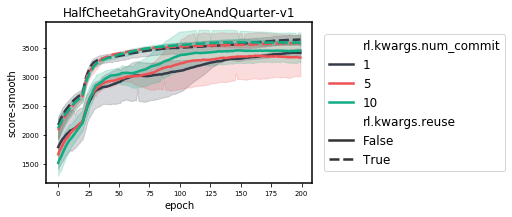

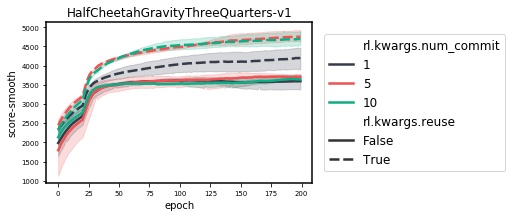

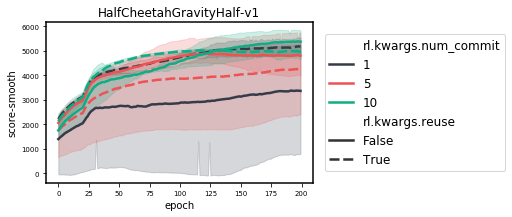

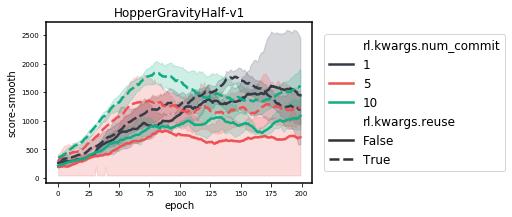

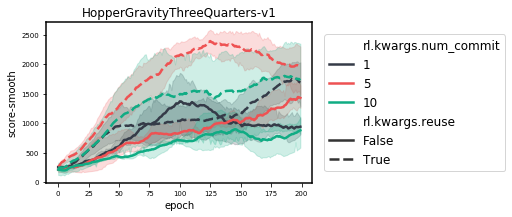

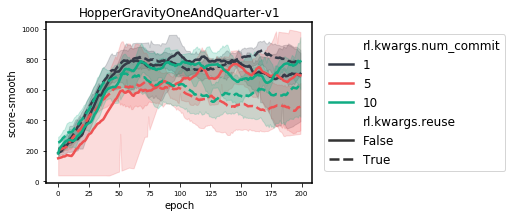

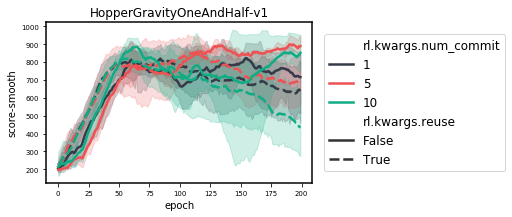

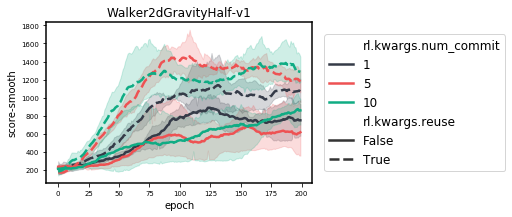

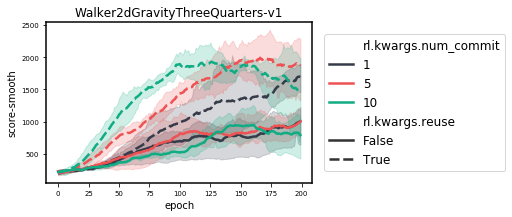

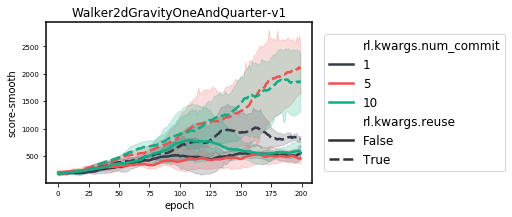

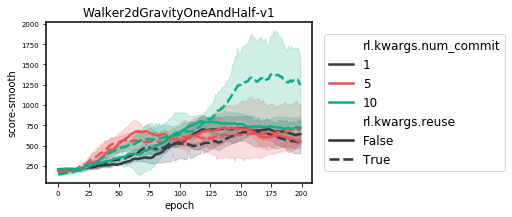

In [44]:
envs = N

for env in envs:
    fig, ax = plt.subplots(1, 1, figsize=set_size(width))

    df = DATA[(DATA['env.name'] == env)]
    x  = sns.lineplot(x="epoch", y="score-smooth", data=df, palette=palette, ax=ax, hue='rl.kwargs.num_commit', style='rl.kwargs.reuse')

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, labels=labels, borderaxespad=1, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(env)